# Web Mining Project - Group 9




Import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/WM-Project/"
%cd /content/drive/My\ Drive/WM-Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cast.tsv	   rating.csv		      result_tags.csv
crew.tsv	   rating_testset.csv	      result_year.csv
genome_scores.csv  rating_testset_small.csv   tag.csv
genome_tags.csv    rating_trainset.csv	      user_pred_df.csv
item_pred_df.csv   rating_trainset_small.csv  WM-Project.ipynb
link.csv	   result_filtering.csv
movie.csv	   result_genre.csv
/content/drive/My Drive/WM-Project


In [2]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports

In [3]:
# Helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

Create Dataframes

In [4]:
# Create Dataframe
df_ratings_trainset = pd.read_csv(
    'rating_trainset_small.csv',
    sep=',',
    header=0,
    names=['userId', 'movieId', 'rating', 'timestamp']
)
df_ratings_trainset.head(3)

,userId,movieId,rating,timestamp
960,11,1,4.5,2009-01-02 01:13:41
961,11,10,2.5,2009-01-02 01:15:59
962,11,19,3.5,2009-01-01 04:21:44


In [5]:
# Create Dataframe
df_ratings_testset = pd.read_csv(
    'rating_testset_small.csv',
    sep=',',
    header=0,
    names=['userId', 'movieId', 'rating', 'timestamp']
)
df_ratings_testset.head(3)

,userId,movieId,rating,timestamp
1315,11.0,30707.0,5.0,2011-01-12 01:36:16
1067,11.0,1544.0,5.0,2009-01-01 05:33:03
1125,11.0,2793.0,5.0,2009-01-01 04:42:38


In [ ]:
# NOT NEEDED ANYMORE due to train test split
# Create Dataframe
df_ratings = pd.read_csv(
    'rating.csv',
    sep=',',
    header=0,
    names=['userId', 'movieId', 'rating', 'timestamp']
)
df_ratings.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [ ]:
df_movies = pd.read_csv(
    'movie.csv',
    sep=',',
    header=0,
    names=['movieId','title','genres']
)
df_movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [ ]:
# Adding some missing release years to the movie titels

df_movies.at[17341,'title'] = df_movies.at[17341,'title'] + (' (2010)')
df_movies.at[15646,'title'] = df_movies.at[15646,'title'] + (' (1970)')
df_movies.at[10593,'title'] = df_movies.at[10593,'title'] + (' (1999)')
df_movies.at[23617,'title'] = df_movies.at[23617,'title'] + (' (2014)')
df_movies.at[23824,'title'] = df_movies.at[23824,'title'] + (' (2014)')
df_movies.at[24286,'title'] = df_movies.at[24286,'title'] + (' (2014)')
df_movies.at[24412,'title'] = df_movies.at[24412,'title'] + (' (2011)')
df_movies.at[26115,'title'] = df_movies.at[26115,'title'] + (' (1990)')
df_movies.at[26127,'title'] = df_movies.at[26127,'title'] + (' (2002)')
df_movies.at[26180,'title'] = df_movies.at[26180,'title'] + (' (2008)')
df_movies.at[26335,'title'] = df_movies.at[26335,'title'] + (' (2013)')
df_movies.at[26395,'title'] = df_movies.at[26395,'title'] + (' (2014)')
df_movies.at[26432,'title'] = df_movies.at[26432,'title'] + (' (1991)')
df_movies.at[26749,'title'] = df_movies.at[26749,'title'] + (' (2015)')
df_movies.at[26784,'title'] = df_movies.at[26784,'title'] + (' (2014)')
df_movies.at[26963,'title'] = df_movies.at[26963,'title'] + (' (2010)')
df_movies.at[26974,'title'] = df_movies.at[26974,'title'] + (' (2014)')
df_movies.at[27027,'title'] = df_movies.at[27027,'title'] + (' (2003)')
df_movies.at[27114,'title'] = df_movies.at[27114,'title'] + (' (1993)')

In [ ]:
# Filter movies because the script works with a smaller dataset
movies = sorted(df_ratings_trainset.movieId.unique())
df_movies = df_movies[df_movies['movieId'].isin(movies)]
df_movies.shape

(10000, 3)

In [ ]:
# Not used
df_gtags = pd.read_csv(
    'genome_tags.csv',
    sep=',',
    header=0,
    names=['tagId','tag' ]
)
df_gtags.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [ ]:
df_gscores = pd.read_csv(
    'genome_scores.csv',
    sep=',',
    header=0,
    names=['movieId','tagId','relevance']
)
df_gscores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [ ]:
# Filter gscores because the script works with a smaller dataset
df_gscores = df_gscores[df_gscores['movieId'].isin(movies)]
df_gscores.shape

(10891968, 3)

In [ ]:
# only use when doing conten-based rec with directors or actors
df_link = pd.read_csv(
    'link.csv',
    sep=',',
    header=0,
    names=['movieId','imdbId', 'tmdbId']
)
df_link = df_link.drop(['tmdbId'], axis=1)
df_link.head(3)

,movieId,imdbId
0,1,114709
1,2,113497
2,3,113228


In [ ]:
# only use when doing conten-based rec with directors
df_crew = pd.read_csv(
    'crew.tsv',
    sep='\t',
    header=0,
    names=['tconst','directors', 'writers']
)
df_crew = df_crew.drop(['writers'], axis=1)
df_crew.head(3)

,tconst,directors
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526


In [ ]:
# only use when doing conten-based rec with actors
df_cast = pd.read_csv(
    'cast.tsv',
    sep='\t',
    header=0,
    names=['tconst','ordering','nconst','category','job','characters']
)
df_cast = df_cast.drop(['ordering','job','characters'], axis=1)
df_cast.head(3)

,tconst,nconst,category
0,tt0000001,nm1588970,self
1,tt0000001,nm0005690,director
2,tt0000001,nm0374658,cinematographer


### Data Analysis

In [ ]:
df_all_ratings = pd.read_csv(
    'rating.csv',
    sep=',',
    header=0,
    names=['userId', 'movieId', 'rating', 'timestamp']
)

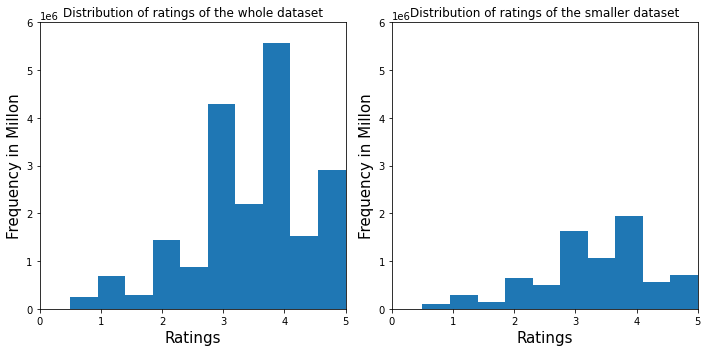

In [ ]:
# Distribution of ratings on the scale of 0 to 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(df_all_ratings['rating'], bins=10)
axes[0].set_title("Distribution of ratings of the whole dataset")
axes[0].set_xlabel("Ratings", fontsize=15)
axes[0].set_ylabel("Frequency in Millon",fontsize=15)
axes[0].set_xlim([0,5.0])
axes[0].set_ylim([0, 6000000])
axes[1].hist(pd.concat([df_ratings_trainset['rating'], df_ratings_testset['rating']]), bins=10)
axes[1].set_title("Distribution of ratings of the smaller dataset")
axes[1].set_xlabel("Ratings", fontsize=15)
axes[1].set_ylabel("Frequency in Millon",fontsize=15)
axes[1].set_xlim([0,5.0])
axes[1].set_ylim([0, 6000000])
fig.tight_layout()

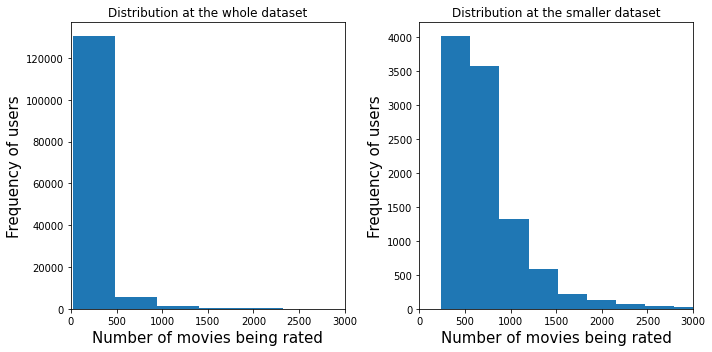

In [ ]:
# Distribution of how many users have how often rated
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(df_all_ratings.groupby(['userId']).size(), bins=20)
axes[0].set_title("Distribution at the whole dataset")
axes[0].set_xlabel("Number of movies being rated", fontsize=15)
axes[0].set_ylabel("Frequency of users",fontsize=15)
axes[0].set_xlim([0,3000])
axes[1].hist(pd.concat([df_ratings_trainset, df_ratings_testset]).groupby(['userId']).size(), bins=20)
axes[1].set_title("Distribution at the smaller dataset")
axes[1].set_xlabel("Number of movies being rated", fontsize=15)
axes[1].set_ylabel("Frequency of users",fontsize=15)
axes[1].set_xlim([0,3000])
fig.tight_layout()


### Preprocessing

Rearrange Movie Dataset

In [ ]:
def year_category (row):
   if row['year'] < 1960 :
      return '0'
   if 1960 <= row['year'] and row['year'] < 1980 :
      return '1'
   if 1980 <= row['year'] and row['year'] < 2000 :
      return '2'
   if 2000 <= row['year'] and row['year'] < 2010 :
      return '3'
   if 2010 <= row['year'] :
      return '4'

In [ ]:
# Split release year from movie titel and asign year categoryies by adding a new column

df_movies_v2 = df_movies.copy()
df_movies_v2[['title', "year"]] = df_movies_v2['title'].str.rsplit('(', 1, expand=True)
df_movies_v2['title'] = df_movies_v2['title'].str.strip()
df_movies_v2['year'] = df_movies_v2['year'].str[:4]
df_movies_v2 = df_movies_v2.astype({'year':'int'})
df_movies_v2['year_category'] = df_movies_v2.apply(lambda row: year_category(row), axis=1)

df_movies_v2.head()

,movieId,title,genres,year,year_category
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,2
1,2,Jumanji,Adventure|Children|Fantasy,1995,2
2,3,Grumpier Old Men,Comedy|Romance,1995,2
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,2
4,5,Father of the Bride Part II,Comedy,1995,2


In [ ]:
# Split up the movie genres and establish a new column for each genre

df_movies_v3 = df_movies_v2.copy()
df_movies_v3['genres'] = df_movies_v3.genres.str.split('|')

for index, row in df_movies_v3.iterrows():
    for genre in row['genres']:
        df_movies_v3.at[index, genre] = 1
df_movies_v3 = df_movies_v3.fillna(0)

df_movies_v3.head()

,movieId,title,genres,year,year_category,Adventure,Animation,Children,Comedy,Fantasy,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,2,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,2,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Make Dataset smaller (to 10000 movies and users)

In [ ]:
# Dosen't have to be run again
#df_ratings = pd.read_csv('rating.csv')

users = sorted(df_ratings.groupby('userId').count().sort_values(by=['movieId'], ascending=False).iloc[:10000, :].index)
print(len(users))
df_less_user = df_ratings[df_ratings['userId'].isin(users)]
movies = sorted(df_less_user.groupby('movieId').count().sort_values(by=['userId'], ascending=False).iloc[:10000, :].index)
print(len(movies))
df_ratings_small = df_less_user[df_less_user['movieId'].isin(movies)]
df_ratings_small

10000
10000


,userId,movieId,rating,timestamp
960,11,1,4.5,2009-01-02 01:13:41
961,11,10,2.5,2009-01-02 01:15:59
962,11,19,3.5,2009-01-01 04:21:44
963,11,32,5.0,2009-01-01 04:11:35
964,11,39,4.5,2009-01-02 01:17:12
...,...,...,...,...
19998294,138474,5401,1.0,2002-07-26 02:47:55
19998295,138474,5449,4.0,2002-07-26 02:47:02
19998296,138474,5459,4.0,2002-07-26 02:47:55
19998297,138474,5460,5.0,2002-07-26 02:47:02


Splitting the Dataset into Train- and Testset


*   Method used: Leave One Last Basket (Random 25% of ratings for each user))

*   Important: This codeblock was already exectued and the resulting train- and testset we exported to csv files so they can be easily reloaded without having to run the very time-consuming splitting algorithm all the time



In [ ]:
# Dosen't have to be run again
# test set: for every user individually select randomly 25% of his ratings as testset
num_ratings = df_ratings_small.copy().drop(['rating', 'timestamp'],axis = 1)
num_ratings = num_ratings.groupby(['userId']).count()
num_ratings["test_size"] = np.floor(num_ratings["movieId"] * 0.25)
num_ratings = num_ratings.astype({"test_size": int})
num_ratings.head(5)

,movieId,test_size
userId,,
11,494,123
24,506,126
54,710,177
58,656,164
91,666,166


In [ ]:
# IMPORTANT: Do not execute again! Very timesconsuming!
# The results (trainset & testset) were stored in csv-files and reloaded in the beginning of this notebook
testset = pd.DataFrame({'userId': [],'movieId': [],'rating': [],'timestamp': []})
index = 1

while (index < 138494):
  if(index in users):
    t = df_ratings_small[df_ratings_small.userId == index].sample(n=num_ratings.at[index, 'test_size'], random_state=1)
    testset = pd.concat([testset,t])
  index += 1

trainset = df_ratings_small.copy()
trainset.drop(testset.index.tolist(), axis=0, inplace=True)

trainset.to_csv('rating_trainset_small.csv')
testset.to_csv('rating_testset_small.csv')

## Baseline

In [ ]:
# Idea: Use the average rating of a movie by all users as a baseline
def avg_movie_rating():
  return df_ratings_trainset.drop(['userId'], axis=1).groupby(['movieId']).mean()

def predict_baseline(movie_ID, grouped_ratings):
  rating = grouped_ratings['rating']
  return rating[movie_ID]

In [ ]:
predict_baseline(4027, avg_movie_rating())

3.892986111111111

## Collaborative Filtering

### Memory-based

In [6]:
df_ratings = df_ratings_trainset.drop('timestamp', axis=1)
df_ratings.head

<bound method NDFrame.head of           userId  movieId  rating
960           11        1     4.5
961           11       10     2.5
962           11       19     3.5
963           11       32     5.0
967           11      145     3.0
...          ...      ...     ...
19998293  138474     5378     4.0
19998295  138474     5449     4.0
19998296  138474     5459     4.0
19998297  138474     5460     5.0
19998298  138474     6425     3.0

[5690035 rows x 3 columns]>

In [ ]:
# Approach to save RAM capacity
'''from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

userId_c = CategoricalDtype(sorted(df_ratings.userId.unique()), ordered=True)
movieId_c = CategoricalDtype(sorted(df_ratings.movieId.unique()), ordered=True)

row = df_ratings.userId.astype(userId_c).cat.codes
col = df_ratings.movieId.astype(movieId_c).cat.codes
matrix = csr_matrix((df_ratings["rating"], (row, col)), \
                           shape=(userId_c.categories.size, movieId_c.categories.size))

# User Similarity Matrix
from sklearn.metrics.pairwise import cosine_similarity
user_correlation = cosine_similarity(matrix.T, dense_output=False)

from scipy.sparse import csc_matrix
def subvec(mat,vec):
   for i in vec.nonzero()[1]:
      mat[:,i] = csc_matrix(mat[:,i].todense() - vec[0,i])
   return mat

# Prediction Matrix
mean_user_rating = matrix.T.mean(axis=1)
ratings_diff = subvec(matrix.T, mean_user_rating)
prediction = mean_user_rating + user_correlation.dot(ratings_diff) / np.array([np.abs(user_correlation).sum(axis=1)]).T

#matrix = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
'''

In [7]:
matrix = df_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
print(matrix.shape)

(10000, 10000)


In [8]:
movies = sorted(df_ratings.movieId.unique())
users = sorted(df_ratings.userId.unique())

#### User-based

In [9]:
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(matrix.T, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation.shape)
user_correlation

(10000, 10000)


array([[1.        , 0.19786972, 0.16004657, ..., 0.22099624, 0.22816563,
        0.19090642],
       [0.19786972, 1.        , 0.27404917, ..., 0.32095158, 0.2086317 ,
        0.26371868],
       [0.16004657, 0.27404917, 1.        , ..., 0.34954419, 0.17351531,
        0.29140226],
       ...,
       [0.22099624, 0.32095158, 0.34954419, ..., 1.        , 0.26727968,
        0.2809815 ],
       [0.22816563, 0.2086317 , 0.17351531, ..., 0.26727968, 1.        ,
        0.15431429],
       [0.19090642, 0.26371868, 0.29140226, ..., 0.2809815 , 0.15431429,
        1.        ]])

In [10]:
mean_user_rating = matrix.T.mean(axis=1)
ratings_diff = (matrix.T - mean_user_rating[:, np.newaxis])
prediction = mean_user_rating[:, np.newaxis] + user_correlation.dot(ratings_diff) / np.array([np.abs(user_correlation).sum(axis=1)]).T
user_prediction = prediction.clip(0)
user_prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[1.86267491, 1.76778206, 0.60985439, ..., 0.01537883, 0.        ,
        0.        ],
       [1.81596953, 1.64781331, 0.64977756, ..., 0.        , 0.        ,
        0.        ],
       [1.85860527, 1.66313136, 0.71271076, ..., 0.02643176, 0.0098853 ,
        0.        ],
       ...,
       [1.84310895, 1.65403438, 0.66262646, ..., 0.01071531, 0.        ,
        0.        ],
       [1.87480563, 1.7102511 , 0.63083941, ..., 0.07226992, 0.04128401,
        0.02258104],
       [1.88989905, 1.78007955, 0.74384758, ..., 0.03920456, 0.01968357,
        0.00518051]])

In [11]:
user_pred_df = pd.DataFrame(user_prediction, index=list(users), columns = list(movies))
user_pred_df.index.name = 'userId'
user_pred_df

,1,2,3,4,5,6,7,8,9,10,...,117590,117881,118696,118700,118702,118900,118997,119141,119145,120635
userId,,,,,,,,,,,,,,,,,,,,,
11,1.862675,1.767782,0.609854,0.058629,0.370430,1.506930,0.451712,0.033160,0.073687,1.329988,...,0.000000,0.000000,0.048622,0.000000,0.000000,0.000000,0.000000,0.015379,0.000000,0.000000
24,1.815970,1.647813,0.649778,0.068517,0.383511,1.581097,0.497444,0.014589,0.066076,1.285866,...,0.000000,0.000000,0.002095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
54,1.858605,1.663131,0.712711,0.130392,0.438306,1.589429,0.576859,0.071804,0.124215,1.343947,...,0.000000,0.000000,0.047325,0.003875,0.000000,0.007419,0.003107,0.026432,0.009885,0.000000
58,1.854182,1.631395,0.683841,0.141614,0.424343,1.642440,0.567568,0.080551,0.128090,1.308256,...,0.018259,0.014714,0.069402,0.023664,0.013428,0.027419,0.022014,0.047641,0.028869,0.014384
91,1.852939,1.688495,0.667579,0.102610,0.412865,1.548775,0.535301,0.054404,0.094032,1.312729,...,0.000000,0.000000,0.045464,0.000000,0.000000,0.000000,0.000000,0.021847,0.001434,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138404,1.856622,1.693262,0.644187,0.084178,0.399127,1.496922,0.525546,0.032918,0.070958,1.281054,...,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
138406,1.851402,1.671424,0.624655,0.102211,0.383067,1.621167,0.490967,0.063533,0.107844,1.324714,...,0.009036,0.004131,0.075939,0.013667,0.002503,0.017966,0.012859,0.047254,0.021377,0.004744
138411,1.843109,1.654034,0.662626,0.091765,0.398747,1.580223,0.520207,0.042906,0.089353,1.318502,...,0.000000,0.000000,0.034058,0.000000,0.000000,0.000000,0.000000,0.010715,0.000000,0.000000


In [12]:
def get_user_prediction(userId, movieId):
  return user_pred_df[movieId][userId]

#### Item-based

In [13]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(matrix, metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation.shape)
item_correlation

(10000, 10000)


array([[1.        , 0.55020642, 0.30115731, ..., 0.11210897, 0.06232897,
        0.05018944],
       [0.55020642, 1.        , 0.40119332, ..., 0.11328429, 0.07961337,
        0.04847336],
       [0.30115731, 0.40119332, 1.        , ..., 0.04236329, 0.0270836 ,
        0.01851226],
       ...,
       [0.11210897, 0.11328429, 0.04236329, ..., 1.        , 0.18618374,
        0.20745473],
       [0.06232897, 0.07961337, 0.0270836 , ..., 0.18618374, 1.        ,
        0.19547691],
       [0.05018944, 0.04847336, 0.01851226, ..., 0.20745473, 0.19547691,
        1.        ]])

In [14]:
# Prediction Matrix
mean_item_rating = matrix.T.mean(axis=0)
ratings_diff2 = (matrix.T - mean_item_rating[np.newaxis, :])
prediction2 = mean_item_rating[np.newaxis, :] + ratings_diff2.dot(item_correlation) / np.array([np.abs(item_correlation).sum(axis=1)])
item_prediction = prediction2.clip(0)
item_prediction.columns = list(movies)
item_prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


,1,2,3,4,5,6,7,8,9,10,...,117590,117881,118696,118700,118702,118900,118997,119141,119145,120635
userId,,,,,,,,,,,,,,,,,,,,,
11,1.754277,1.576517,0.551582,0.000000,0.315533,1.417140,0.403898,0.012599,0.035471,1.189874,...,0.000427,0.000000,0.076581,0.000000,0.000000,0.000000,0.000000,0.036881,0.003814,0.038106
24,1.747005,1.548587,0.584085,0.069693,0.349766,1.438389,0.456530,0.016050,0.064533,1.180200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
54,1.856716,1.654556,0.704119,0.205243,0.469319,1.546082,0.593181,0.125724,0.193055,1.304390,...,0.000000,0.000000,0.008325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58,1.928633,1.718883,0.744759,0.251859,0.509373,1.644116,0.647847,0.132044,0.208620,1.364247,...,0.000408,0.028867,0.071842,0.045338,0.008834,0.042567,0.014925,0.043894,0.026859,0.000000
91,1.857437,1.666258,0.678248,0.139758,0.448928,1.538715,0.561267,0.087963,0.117581,1.296572,...,0.000000,0.000000,0.050130,0.000000,0.000000,0.002264,0.000000,0.019982,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138404,1.780324,1.587314,0.601498,0.095821,0.378960,1.443592,0.495415,0.047633,0.062081,1.205986,...,0.000000,0.000000,0.007403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
138406,1.810559,1.602532,0.590413,0.056234,0.347881,1.512377,0.462415,0.020827,0.074772,1.240078,...,0.008080,0.039652,0.091151,0.023459,0.000000,0.026382,0.016803,0.061768,0.024869,0.004353
138411,1.851956,1.653407,0.677281,0.134052,0.439815,1.548007,0.552464,0.073311,0.136255,1.298669,...,0.000000,0.000000,0.037698,0.000000,0.000000,0.000000,0.000000,0.005950,0.000000,0.000000


In [15]:
def get_item_prediction(userId, movieId):
    return item_prediction[movieId][userId]

Performance of Item & User

In [16]:
ratings_testset = df_ratings_testset.copy()
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()

cf_rating = ratings_testset[['rating']].copy()
cf_rating = cf_rating.rename({"rating": "Real_Rating"}, axis=1)
cf_rating['item'] = 0.0
cf_rating['user'] = 0.0

for index, row in user_movie_pairs.iterrows():
  cf_rating.at[index, 'item'] = get_item_prediction(row['userId'], row['movieId'])
  cf_rating.at[index, 'user'] = get_user_prediction(row['userId'], row['movieId'])

In [17]:
print("Results CF Item - all data")
print("MAE: ", mean_absolute_error(cf_rating['Real_Rating'], cf_rating['item']))
print("RMSE: ", mean_squared_error(cf_rating['Real_Rating'], cf_rating['item'], squared=False))

print("NDCG@10: ", ndcg_score([cf_rating['Real_Rating']], [cf_rating['item']], k=10))
print("NDCG@100: ", ndcg_score([cf_rating['Real_Rating']], [cf_rating['item']], k=100))

Results CF Item - all data
MAE:  2.51754806929472
RMSE:  2.7270908899295505
NDCG@10:  0.9510824833138486
NDCG@100:  0.9337173508536073


In [18]:
print("Results CF User - all data")
print("MAE: ", mean_absolute_error(cf_rating['Real_Rating'], cf_rating['user']))
print("RMSE: ", mean_squared_error(cf_rating['Real_Rating'], cf_rating['user'], squared=False))

print("NDCG@10: ", ndcg_score([cf_rating['Real_Rating']], [cf_rating['user']], k=10))
print("NDCG@100: ", ndcg_score([cf_rating['Real_Rating']], [cf_rating['user']], k=100))

Results CF User - all data
MAE:  2.5325303755187005
RMSE:  2.744651402681255
NDCG@10:  0.9095846871037413
NDCG@100:  0.9082260466811105


### Model-based

In [6]:
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import SVD, NMF, KNNBasic, KNNWithMeans

reader = Reader(rating_scale=(0, 5))
trainset = df_ratings_trainset.drop('timestamp', axis=1).groupby('userId').filter(lambda x: len(x) >= 0)[['userId','movieId','rating']]
testset = df_ratings_testset.drop('timestamp', axis=1).groupby('userId').filter(lambda x: len(x) >= 0)[['userId','movieId','rating']]
trainset.index = range(len(trainset)) 
testset.index = range(len(testset)) 
trainset = Dataset.load_from_df(trainset, reader)
testset = testset.values.tolist()

# Define the models and their hyperparameters
sim_option_item_cos = {'name': 'cosine',
              'user_based': False  # compute similarities between items
               }
sim_option_user_pea = {'name': 'pearson',
              'user_based': True  # compute similarities between users
               }

In [ ]:
# Very timesconsuming! The results are shown in the report.
benchmark = []
i = 0
alg_list = ['KNNBasic(k=10, sim=cosine, item-based)',
            'KNNBasic(k=20, sim=cosine, item-based)',
            'KNNBasic(k=50, sim=cosine, item-based)',
            'KNNBasic(k=20, sim=pearson, user-based)',
            'KNNWithMeans(k=20, sim=cosine, item-based)',
            'SVD(n_factors=30)',
            'SVD(n_factors=50)', 
            'SVD(n_factors=100)',
            'SVD(n_factors=150)', 
            'NMF(n_factors=15)',
            'NMF(n_factors=30)']
for algorithm in [KNNBasic(k=10, sim_options=sim_option_item_cos), 
                  KNNBasic(k=20, sim_options=sim_option_item_cos), 
                  KNNBasic(k=50, sim_options=sim_option_item_cos),
                  KNNBasic(k=20, sim_options=sim_option_user_pea),
                  KNNWithMeans(k=20, sim_options=sim_option_item_cos), 
                  SVD(n_factors=30),
                  SVD(n_factors=50), 
                  SVD(n_factors=100), 
                  SVD(n_factors=150), 
                  NMF(n_factors=15),
                  NMF(n_factors=30)]:
    # Perform cross validation
    results = cross_validate(algorithm, trainset, measures=['RMSE','MAE'], cv=5, verbose=False)
    print('Done')

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([alg_list[i]], index=['Algorithm']))
    benchmark.append(tmp)
    i+=1
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [7]:
# Since SVD(n_factors=50) reach the lowest RMSE and MAE
# We use this model to train on whole training set and evaluate the final result on testset
trainset = trainset.build_full_trainset()
algorithm = SVD(n_factors=50)
model_svd = algorithm.fit(trainset)
predictions = model_svd.test(testset)

# Check the accuracy using Root Mean Square Error
print(accuracy.rmse(predictions))
# Check the accuracy using Mean Absolute Error
print(accuracy.mae(predictions))

RMSE: 0.7377
0.7376906041145854
MAE:  0.5614
0.5614057604953729


In [8]:
from collections import Counter
df_pred = pd.DataFrame(predictions, columns=['userId', 'movieId', 'rating', 'pred_rating', 'details'])
print(df_pred.shape)
df_pred.head(5)

(1891802, 5)


,userId,movieId,rating,pred_rating,details
0,11.0,30707.0,5.0,4.327085,{'was_impossible': False}
1,11.0,1544.0,5.0,4.515701,{'was_impossible': False}
2,11.0,2793.0,5.0,3.683271,{'was_impossible': False}
3,11.0,3753.0,5.0,4.236544,{'was_impossible': False}
4,11.0,59014.0,2.0,3.041010,{'was_impossible': False}


In [ ]:
def get_predicition(userId, movieId):
  return df_pred[df_pred['userId'] == userId][df_pred['movieId'] == movieId].pred_rating
print(get_predicition(11, 1544))

1    4.441358
Name: pred_rating, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [39]:
print("Results CF Model - all data")
print("MAE: ", mean_absolute_error(df_pred['rating'], df_pred['pred_rating']))
print("RMSE: ", mean_squared_error(df_pred['rating'], df_pred['pred_rating'], squared=False))

print("NDCG@10: ", ndcg_score([df_pred['rating']], [df_pred['pred_rating']], k=10))
print("NDCG@100: ", ndcg_score([df_pred['rating']], [df_pred['pred_rating']], k=100))

Results CF Model - all data
MAE:  0.5614057604953729
RMSE:  0.7376906041145854
NDCG@10:  0.9779702420608483
NDCG@100:  0.9779702420608487


## Content-based Filtering

###Movie Genre

In [ ]:
# Cosine similarity matrix for all movies based on genre
movies = (df_movies_v3.copy()).reset_index(drop=True)
movies = movies.drop(['movieId','title', 'genres', 'year', 'year_category'], axis = 1)
sim_matrix_genre = cosine_similarity(movies)
#print(sim_matrix_genre)

# df_movies_v3 with new index
movies_v4 = (df_movies_v3.copy()).reset_index(drop=True)


In [ ]:
def predict_v1(user_ID, movie_ID):#, top_n):
  top_n = 7
  # Get the ratings of user_ID
  df_ratings_user = df_ratings_trainset.drop(['timestamp'], axis = 1)
  df_ratings_user = df_ratings_user.loc[df_ratings_user["userId"] == user_ID]
  #df_ratings_user = df_ratings_user.drop(df_ratings_user[df_ratings_user['movieId'] == movie_ID ].index) #not needed anymore due to split
  #print(df_ratings_user)

  # Select row in matrix for movie_ID
  sim_movie = sim_matrix_genre[int(movies_v4[movies_v4['movieId'] == movie_ID].index[0])]
  df_sim_movie = pd.DataFrame(sim_movie, columns=['similarity'])
  df_sim_movie['movieId'] = movies_v4['movieId'].copy()
  #print(df_sim_movie)

  # Rating of movie_ID = The weighted sum of the top_n most similar movies 
  df_ratings_user = pd.merge(df_ratings_user,df_sim_movie,on='movieId',how='left')
  df_ratings_user = df_ratings_user.sort_values('similarity', ascending=False)
  df_ratings_user = df_ratings_user[:top_n]
  #print(df_ratings_user)

  rating = 0
  totalSum = df_ratings_user['similarity'].sum()
  for index, row in df_ratings_user.iterrows():
    rating = rating + (row['rating'] * (row['similarity'] / totalSum))

  return rating

In [ ]:
# NOT USED ANYMORE
# Old (way slower) version without the use of a matrix 
def predict_v1_old(user_ID, movie_ID, top_n):
  # Get the ratings of user_ID
  df_ratings_user = df_ratings_trainset.copy()
  df_ratings_user = df_ratings_user.drop(['timestamp'], axis = 1)
  df_ratings_user = df_ratings_user.loc[df_ratings_user["userId"] == user_ID]
  #df_ratings_user = df_ratings_user.drop(df_ratings_user[df_ratings_user['movieId'] == movie_ID ].index) #not needed anymore due to split
  #print(df_ratings_user)

  # Get a list of movieId's of all seen movies of user_ID
  seen_movies = df_ratings_user['movieId'].copy().values.tolist()
  #print(seen_movies)

  # Select only the seen movies
  movies = df_movies_v3.copy()
  movies = movies.drop(['title', 'genres', 'year', 'year_category'], axis = 1)
  movies = movies[movies['movieId'].isin(seen_movies)]
  #movies = movies.drop(movies[movies['movieId'] == movie_ID ].index) #not needed anymore due to split
  movies = movies.drop(['movieId'], axis = 1)
  # Possible Improvement: Normalization of genres (?)
  #print(movies)

  # Get genre description of movie_ID
  movie_genre = df_movies_v3.copy()
  movie_genre = movie_genre.drop(['title', 'genres', 'year', 'year_category'], axis = 1)
  movie_genre = (movie_genre.loc[movie_genre['movieId'] == movie_ID]).transpose()
  movie_genre = movie_genre.drop(movie_genre.index[0])
  #print(movie_genre) 
  
  ########

  # Compute the cosine similarity between every movie from 'movies' and movie_ID based on their genre description
  movies_similarity = df_ratings_user.copy()
  movies_similarity["similarity"] = np.nan
  movies_similarity = movies_similarity.reset_index(drop=True)
  #print(movies_similarity)

  i = 0
  for index, row in movies.iterrows():
    movies_similarity.at[i, 'similarity'] = 1 - cosine(row, movie_genre)
    i = i + 1

  # Rating of movie_ID = The weighted sum of the top_n most similar movies 
  movies_similarity = movies_similarity.sort_values('similarity', ascending=False)
  movies_similarity = movies_similarity[:top_n]
  #print(movies_similarity)
  
  rating = 0
  totalSum = movies_similarity['similarity'].sum()
  for index, row in movies_similarity.iterrows():
    rating = rating + (row['rating'] * (row['similarity'] / totalSum))

  return rating

In [ ]:

user_ID = 1
movie_ID = 4027
top_n = 3

print(predict_v1(user_ID, movie_ID, top_n))


4.000000000000001


###Release Year

In [ ]:
def predict_v2(user_ID, movie_ID):
  # Get the ratings of user_ID
  df_ratings_user = df_ratings_trainset.drop(['timestamp'], axis = 1)
  df_ratings_user = df_ratings_user.loc[df_ratings_user["userId"] == user_ID]
  #df_ratings_user = df_ratings_user.drop(df_ratings_user[df_ratings_user['movieId'] == movie_ID ].index) #not needed anymore due to split
  #print(df_ratings_user)

  # Get a list of movieId's of all seen movies of user_ID
  seen_movies = df_ratings_user['movieId'].copy().values.tolist()
  #print(seen_movies)

  # Select only the seen movies
  movies = df_movies_v2.copy()
  movies = movies.drop(['title', 'genres', 'year'], axis = 1)
  movies = movies[movies['movieId'].isin(seen_movies)]
  #movies = movies.drop(movies[movies['movieId'] == movie_ID ].index) #not needed anymore due to split
  #print(movies)

  # Combine user ratings and year category of seen movies
  combined_df = pd.merge(df_ratings_user, movies, left_on='movieId', right_on='movieId', how='left').drop('movieId', axis=1)
  combined_df = combined_df.drop('userId', axis=1)
  #print(combined_df)

  # Rating of movie_ID = Mean of the ratings of seen movies with the same year category as movie_ID 
  movie_year_category = df_movies_v2.loc[df_movies_v2['movieId'] == movie_ID, 'year_category'].values[0]
  combined_df = combined_df.loc[combined_df['year_category'] == movie_year_category]
  if len(combined_df) != 0:
    rating = combined_df['rating'].mean()
  else:
    rating = predict_baseline(movie_ID, avg_movie_rating())

  return rating


In [ ]:
user_ID = 1
movie_ID = 4027

print(predict_v2(user_ID, movie_ID))

3.96


###Content Summary (Movie Tags)

In [ ]:
# Cosine similarity matrix for all movies based on genome tag relvance
gscores = df_gscores.copy()
gscores_pivoted = gscores.copy().pivot(index="movieId", columns="tagId", values="relevance")

sim_matrix_tags = cosine_similarity(gscores_pivoted)
#print(sim_matrix_tags)

gscores_pivoted = gscores_pivoted.reset_index()

In [ ]:
def predict_v3(user_ID, movie_ID, top_n):
  # Get the ratings of user_ID
  df_ratings_user = df_ratings_trainset.drop(['timestamp'], axis = 1)
  df_ratings_user = df_ratings_user.loc[df_ratings_user["userId"] == user_ID]
  #df_ratings_user = df_ratings_user.drop(df_ratings_user[df_ratings_user['movieId'] == movie_ID ].index) #not needed anymore due to split
  #print(df_ratings_user)

  # Select row in matrix for movie_ID
  sim_movie = sim_matrix_tags[int(gscores_pivoted[gscores_pivoted['movieId'] == movie_ID].index[0])]
  df_sim_movie = pd.DataFrame(sim_movie, columns=['similarity'])
  df_sim_movie['movieId'] = gscores_pivoted['movieId'].copy()
  #print(df_sim_movie)

  # Rating of movie_ID = The weighted sum of the top_n most similar movies 
  df_ratings_user = pd.merge(df_ratings_user,df_sim_movie,on='movieId',how='left')
  df_ratings_user = df_ratings_user.sort_values('similarity', ascending=False)
  df_ratings_user = df_ratings_user[:top_n]
  #print(df_ratings_user)

  rating = 0
  totalSum = df_ratings_user['similarity'].sum()
  for index, row in df_ratings_user.iterrows():
    rating = rating + (row['rating'] * (row['similarity'] / totalSum))

  return rating

In [ ]:
# NOT USED ANYMORE
# Old (way slower) version without the use of a matrix 
def predict_v3_old(user_ID, movie_ID, top_n):
  # Get the ratings of user_ID
  df_ratings_user = df_ratings_trainset.copy()
  df_ratings_user = df_ratings_user.drop(['timestamp'], axis = 1)
  df_ratings_user = df_ratings_user.loc[df_ratings_user["userId"] == user_ID]
  #print(df_ratings_user)

  # Get a list of movieId's of all seen movies of user_ID
  seen_movies = df_ratings_user['movieId'].copy().values.tolist()
  #print(seen_movies)

  # Select only gscores of seen movies
  gscores = df_gscores.copy()
  gscores = gscores[gscores['movieId'].isin(seen_movies)]
  gscores_pivoted = gscores.copy().pivot(index="movieId", columns="tagId", values="relevance")
  #print(gscores_pivoted)

  # Get gscores of movie_ID
  movie_relevance = df_gscores.copy()
  movie_relevance = movie_relevance.loc[movie_relevance['movieId'] == movie_ID]
  movie_relevance = (movie_relevance.pivot(index="movieId", columns="tagId", values="relevance")).transpose()
  #print(movie_relevance)

  #gscores_pivoted = gscores_pivoted.drop(index = movie_ID) #not needed anymore due to split
  #print(gscores_pivoted) 

  ########

  # Compute the cosine similarity between the gscores of every seen movie and movie_ID
  movies_similarity = df_ratings_user.copy()
  #movies_similarity = movies_similarity.drop(movies_similarity[movies_similarity['movieId'] == movie_ID ].index) #not needed anymore due to split
  movies_similarity["similarity"] = np.nan
  movies_similarity = movies_similarity.reset_index(drop=True)
  #print(movies_similarity)

  i = 0
  for index, row in gscores_pivoted.iterrows():
    movies_similarity.at[i, 'similarity'] = 1 - cosine(row, movie_relevance)
    i = i + 1
  
  # Rating of movie_ID = The weighted sum of the top_n most similar movies 
  movies_similarity = movies_similarity.sort_values('similarity', ascending=False)
  movies_similarity = movies_similarity[:top_n]
  #print(movies_similarity)
  
  rating = 0
  totalSum = movies_similarity['similarity'].sum()
  for index, row in movies_similarity.iterrows():
    rating = rating + (row['rating'] * (row['similarity'] / totalSum))

  return rating

In [ ]:
user_ID = 1
movie_ID = 4027
top_n = 5

print(predict_v3(user_ID, movie_ID, top_n))

3.3983778115473458


###Director

In [ ]:
# Format movie ids (tconst) so it matches the imdbId from df_link
x = df_crew.copy()
x['tconst'] = x['tconst'].str[2:]
x = x.astype({'tconst':'int'})
x

,tconst,directors
0,1,nm0005690
1,2,nm0721526
2,3,nm0721526
3,4,nm0721526
4,5,nm0005690
...,...,...
8915463,9916848,"nm5519454,nm5519375"
8915464,9916850,"nm5519375,nm5519454"
8915465,9916852,"nm5519375,nm5519454"
8915466,9916856,nm10538645


In [ ]:
directors = df_link.copy()
directors = directors.merge(x, how='left', left_on='imdbId', right_on='tconst')
directors

,movieId,imdbId,tconst,directors
0,1,114709,114709.0,nm0005124
1,2,113497,113497.0,nm0002653
2,3,113228,113228.0,nm0222043
3,4,114885,114885.0,nm0001845
4,5,113041,113041.0,nm0796124
...,...,...,...,...
27273,131254,466713,466713.0,nm0377153
27274,131256,277703,277703.0,nm0227845
27275,131258,3485166,3485166.0,nm2463304
27276,131260,249110,249110.0,nm0463581


In [ ]:
# index of movies from movielens20m dataset that dont have a director listed in imdb dataset - Part 1
a = directors.index[directors['directors'] == "\\N"].tolist()

In [ ]:
# index of movies from movielens20m dataset that dont have a director listed in imdb dataset - Part 2
b = directors.loc[pd.isna(directors["tconst"]), :].index

In [ ]:
# all nan values removed
directors_cliped = directors.copy()
directors_cliped = directors_cliped.drop(a)
directors_cliped = directors_cliped.drop(b)
directors_cliped

,movieId,imdbId,tconst,directors
0,1,114709,114709.0,nm0005124
1,2,113497,113497.0,nm0002653
2,3,113228,113228.0,nm0222043
3,4,114885,114885.0,nm0001845
4,5,113041,113041.0,nm0796124
...,...,...,...,...
27273,131254,466713,466713.0,nm0377153
27274,131256,277703,277703.0,nm0227845
27275,131258,3485166,3485166.0,nm2463304
27276,131260,249110,249110.0,nm0463581


In [ ]:
rslt_df = directors_cliped[directors_cliped['directors'].str.len() > 29]
print(len(rslt_df))

196


In [ ]:
directors_cliped['directors'] = directors_cliped.directors.str.split(',')

In [ ]:
#def predict_v4(user_ID, movie_ID):
user_ID = 104
movie_ID = 1797

# Get the ratings of user_ID
df_ratings_user = df_ratings_trainset.copy()
df_ratings_user = df_ratings_user.drop(['timestamp'], axis = 1)
df_ratings_user = df_ratings_user.loc[df_ratings_user["userId"] == user_ID]
#df_ratings_user = df_ratings_user.drop(df_ratings_user[df_ratings_user['movieId'] == movie_ID ].index) #not needed anymore due to split
#print(df_ratings_user)

# Get a list of movieId's of all seen movies of user_ID
seen_movies = df_ratings_user['movieId'].copy().values.tolist()
#print(seen_movies)

# Select only the seen movies
movies = directors_cliped.copy()
movies = movies.drop(['imdbId', 'tconst'], axis = 1)
movies = movies[movies['movieId'].isin(seen_movies)]
#print(movies)

# Get directors of movie_ID
movie_directors = directors_cliped.copy()
movie_directors = movie_directors.drop(['imdbId', 'tconst'], axis = 1)
movie_directors = (movie_directors.loc[movie_directors['movieId'] == movie_ID]).reset_index(drop=True)
#print(movie_directors)

# Combine user ratings and director(s) of seen movies
combined_df = pd.merge(df_ratings_user, movies, left_on='movieId', right_on='movieId', how='inner')#.drop('movieId', axis=1)
combined_df["similarity"] = 0
#print(combined_df)

# 
for director in movie_directors['directors'][0]:
  for index, row in combined_df.iterrows():
    if director in row['directors'] :
      combined_df.at[index, 'similarity'] = row['similarity'] + 1   
print(combined_df)
print(combined_df['similarity'].sum())

#  return rating


       userId  movieId  rating
11454     104       14     1.0
11455     104       17     3.0
11456     104       21     3.0
11457     104       25     4.0
11458     104       28     3.0
...       ...      ...     ...
12447     104     3266     3.0
12448     104     4424     4.0
12449     104     4970     3.0
12450     104     5060     5.0
12451     104     5649     2.0

[997 rows x 3 columns]
[14, 17, 21, 25, 28, 29, 30, 32, 34, 36, 39, 41, 43, 45, 47, 50, 58, 59, 63, 68, 69, 79, 81, 82, 83, 84, 86, 97, 111, 119, 121, 123, 125, 144, 150, 154, 155, 156, 157, 162, 164, 166, 175, 176, 180, 187, 199, 209, 211, 213, 215, 230, 232, 233, 235, 242, 245, 246, 247, 260, 261, 262, 265, 268, 271, 272, 281, 288, 290, 291, 296, 300, 303, 306, 307, 309, 312, 314, 318, 326, 329, 333, 334, 337, 338, 339, 345, 352, 357, 381, 384, 387, 388, 390, 408, 412, 417, 426, 431, 440, 441, 446, 447, 448, 449, 457, 467, 471, 474, 475, 476, 477, 481, 482, 486, 492, 495, 497, 498, 501, 508, 509, 514, 521, 526, 527, 5

### Actors

In [ ]:
# Format movie ids (tconst) so it matches the imdbId from df_link
# Use only the entries about the actors
y = df_cast.copy()
y = y[y['category'] == "actor"]
y['tconst'] = y['tconst'].str[2:]
y = y.astype({'tconst':'int'})
y

,tconst,nconst,category
11,5,nm0443482,actor
12,5,nm0653042,actor
16,7,nm0179163,actor
17,7,nm0183947,actor
21,8,nm0653028,actor
...,...,...,...
50284961,9916852,nm5519557,actor
50284962,9916852,nm8825009,actor
50284972,9916856,nm10538646,actor
50284978,9916880,nm1483166,actor


In [ ]:
# fuse actor rows
y = y.drop(['category'], axis=1)
aggregation_function = {'nconst': 'unique'}
y = y.groupby(y['tconst']).aggregate(aggregation_function)
y

,nconst
tconst,
5,"[nm0443482, nm0653042]"
7,"[nm0179163, nm0183947]"
8,[nm0653028]
9,"[nm0183823, nm1309758]"
11,[nm3692297]
...,...
20223470,[nm13658561]
20223478,[nm13658567]
20223482,[nm1057058]


In [ ]:
actors = df_link.copy()
actors = actors.merge(y, how='left', left_on='imdbId', right_on='tconst')
actors

,movieId,imdbId,nconst
0,1,114709,"[nm0000158, nm0000741, nm0725543, nm0001815]"
1,2,113497,"[nm0000245, nm0404993]"
2,3,113228,"[nm0000527, nm0000493]"
3,4,114885,NaN
4,5,113041,"[nm0000188, nm0001737]"
...,...,...,...
27273,131254,466713,"[nm1307343, nm0525518, nm0825398, nm2395653]"
27274,131256,277703,"[nm0442622, nm0825398, nm0645178]"
27275,131258,3485166,"[nm2339825, nm1041999, nm0497710]"
27276,131260,249110,"[nm0839432, nm0463568]"


In [ ]:

# index of movies from movielens20m dataset that dont have a director listed in imdb dataset - Part 2
b = actors.loc[pd.isna(actors["nconst"]), :].index
b

Int64Index([    3,    26,    45,    76,   106,   125,   126,   134,   160,
              180,
            ...
            27172, 27181, 27185, 27194, 27210, 27212, 27216, 27225, 27230,
            27235],
           dtype='int64', length=2484)

In [ ]:
# all nan values removed
actors_cliped = actors.copy()
actors_cliped = actors_cliped.drop(b)
actors_cliped

,movieId,imdbId,nconst
0,1,114709,"[nm0000158, nm0000741, nm0725543, nm0001815]"
1,2,113497,"[nm0000245, nm0404993]"
2,3,113228,"[nm0000527, nm0000493]"
4,5,113041,"[nm0000188, nm0001737]"
5,6,113277,"[nm0000199, nm0000134, nm0000174, nm0000685]"
...,...,...,...
27273,131254,466713,"[nm1307343, nm0525518, nm0825398, nm2395653]"
27274,131256,277703,"[nm0442622, nm0825398, nm0645178]"
27275,131258,3485166,"[nm2339825, nm1041999, nm0497710]"
27276,131260,249110,"[nm0839432, nm0463568]"


In [ ]:
#def predict_v4(user_ID, movie_ID):
user_ID = 104
movie_ID = 1797

# Get the ratings of user_ID
df_ratings_user = df_ratings_trainset.copy()
df_ratings_user = df_ratings_user.drop(['timestamp'], axis = 1)
df_ratings_user = df_ratings_user.loc[df_ratings_user["userId"] == user_ID]
#df_ratings_user = df_ratings_user.drop(df_ratings_user[df_ratings_user['movieId'] == movie_ID ].index) #not needed anymore due to split
print(df_ratings_user)

# Get a list of movieId's of all seen movies of user_ID
seen_movies = df_ratings_user['movieId'].copy().values.tolist()
print(seen_movies)

# Select only the seen movies
movies = actors_cliped.copy()
movies = movies.drop(['imdbId'], axis = 1)
movies = movies[movies['movieId'].isin(seen_movies)]
print(movies)

# Get actors of movie_ID
movie_actors = actors_cliped.copy()
movie_actors = movie_actors.drop(['imdbId'], axis = 1)
movie_actors = (movie_actors.loc[movie_actors['movieId'] == movie_ID]).reset_index(drop=True)
print(movie_actors)

# Combine user ratings and director(s) of seen movies
combined_df = pd.merge(df_ratings_user, movies, left_on='movieId', right_on='movieId', how='inner')#.drop('movieId', axis=1)
combined_df["similarity"] = 0
print(combined_df)

for actor in movie_actors['nconst'][0]:
  for index, row in combined_df.iterrows():
    if actor in row['nconst'] :
      combined_df.at[index, 'similarity'] = row['similarity'] + 1   
print(combined_df)
print(combined_df['similarity'].sum())

#  return rating


## Hybrid Recommender

In [ ]:
# OLD Version - Hybrid Prediction is now calculated within the evaluation chapter
def predict_hybrid(user_ID, movie_ID, top_n):
  CF_User = 0
  CB_Genre = predict_v1(user_ID, movie_ID, top_n)
  CB_Release_Year = predict_v2(user_ID, movie_ID)
  CB_Tags = predict_v3(user_ID, movie_ID, top_n)

  hybrid_rating = ((CB_Genre + CB_Release_Year + CB_Tags)/3.0)
  #hybrid_rating = ((CF_User + CB_Genre + CB_Release_Year + CB_Tags)/4.0)

  #print("CF_User: ", CF_User, "\nCB_Genre: ", CB_Genre, "\nCB_Release_Year: ", CB_Release_Year, "\nCB_Tags: ", CB_Tags)
  #print("\nHybrid: ", hybrid_rating)

  return hybrid_rating


In [ ]:
user_ID = 1
movie_ID = 4027
top_n = 3

predict_hybrid(user_ID, movie_ID, top_n)

CF_User:  0 
CB_Genre:  4.000000000000001 
CB_Release_Year:  3.96 
CB_Tags:  3.332742986158087

Hybrid:  3.764247662052696


## Optimisation

In [ ]:
def optimize_recommender(name_recommender, top_n):
  ratings_trainset = df_ratings_trainset.copy()
  user_movie_pairs  = ratings_trainset[['userId', 'movieId']].copy()
  user_movie_pairs = user_movie_pairs.head(10000) # just for initial testing
  #print(user_movie_pairs)

  rating = ratings_trainset[['rating']].copy()
  rating = rating.rename({"rating": "Real_Rating"}, axis=1)
  rating['Pred_Rating'] = 0.0
  rating = rating.head(10000) # just for initial testing

  u = 0
  for index, row in user_movie_pairs.iterrows():
    try:
      if name_recommender == "genre":
        rating.at[index, 'Pred_Rating'] = predict_v1(row['userId'], row['movieId'], top_n)
      elif name_recommender == "tags":
        rating.at[index, 'Pred_Rating'] = predict_v3(row['userId'], row['movieId'], top_n)
      else:
        print("This Recommender Version doesn't exist")
        break
      u += 1
    except KeyError:
      print(row['userId']," & ",row['movieId'])
      rating.at[index, 'Pred_Rating'] = 0.0

  print("Performance of ", name_recommender, ", top_n = ", top_n, ":")
  print("MAE: ", mean_absolute_error(rating['Real_Rating'], rating['Pred_Rating']))
  print("RMSE: ", mean_squared_error(rating['Real_Rating'], rating['Pred_Rating'], squared=False))

In [ ]:
optimize_recommender("genre", 2)

Performance of  genre , top_n =  2 :
MAE:  0.8460129073916596
RMSE:  1.0920299246065197


In [ ]:
optimize_recommender("genre", 3)

Performance of  genre , top_n =  3 :
MAE:  0.8070635213229838
RMSE:  1.0343588850431118


In [ ]:
optimize_recommender("genre", 4)

Performance of  genre , top_n =  4 :
MAE:  0.7866750803055872
RMSE:  1.0045350788196596


In [ ]:
optimize_recommender("genre", 5)

Performance of  genre , top_n =  5 :
MAE:  0.7742236471674633
RMSE:  0.9861801980993445


In [ ]:
optimize_recommender("genre", 6)

Performance of  genre , top_n =  6 :
MAE:  0.6805847647574073
RMSE:  0.8703567912093242


In [ ]:
optimize_recommender("genre", 7)

Performance of  genre , top_n =  7 :
MAE:  0.6788269527586881
RMSE:  0.8685496054524122


In [ ]:
def optimize_tags_recommender(top_n):
  ratings_trainset = df_ratings_trainset.copy()
  user_movie_pairs  = ratings_trainset[['userId', 'movieId','rating']].copy()
  movies_with_gtags = sorted(gscores_pivoted.movieId.unique())
  user_movie_pairs = user_movie_pairs[user_movie_pairs['movieId'].isin(movies_with_gtags)]
  user_movie_pairs = user_movie_pairs.head(10000) # just for initial testing

  rating = user_movie_pairs[['rating']].copy()
  user_movie_pairs = user_movie_pairs.drop(['rating'], axis=1)
  rating = rating.rename({"rating": "Real_Rating"}, axis=1)
  rating['Pred_Rating'] = 0.0
  rating = rating.head(10000) # just for initial testing

  for index, row in user_movie_pairs.iterrows():
      try:
        rating.at[index, 'Pred_Rating'] = predict_v3(row['userId'], row['movieId'], top_n)
      except KeyError:
        print(row['userId']," & ",row['movieId'])
        rating.at[index, 'Pred_Rating'] = 0.0

  print("Performance of Tags, top_n = ", top_n, ":")
  print("MAE: ", mean_absolute_error(rating['Real_Rating'], rating['Pred_Rating']))
  print("RMSE: ", mean_squared_error(rating['Real_Rating'], rating['Pred_Rating'], squared=False))

In [ ]:
optimize_tags_recommender(2)

Performance of Tags, top_n =  2 :
MAE:  0.3776585693617031
RMSE:  0.5166570484371917


In [ ]:
optimize_tags_recommender(3)

Performance of Tags, top_n =  3 :
MAE:  0.46601822018404243
RMSE:  0.6119094311027631


In [ ]:
optimize_tags_recommender(4)

Performance of Tags, top_n =  4 :
MAE:  0.5029768682864915
RMSE:  0.6548604873621233


In [ ]:
optimize_tags_recommender(5)

Performance of Tags, top_n =  5 :
MAE:  0.5261470263253855
RMSE:  0.6821123323455863


In [ ]:
optimize_tags_recommender(6)

Performance of Tags, top_n =  6 :
MAE:  0.5419495934030777
RMSE:  0.7012309893855506


In [ ]:
optimize_tags_recommender(7)

Performance of Tags, top_n =  7 :
MAE:  0.551322712816934
RMSE:  0.7123478855817194


## Evaluation

Item and User based Collaborative Filtering

In [103]:
# Dosen't have to be run again
ratings_testset = df_ratings_testset.copy()
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()
user_movie_pairs = user_movie_pairs.head(40000)
#print(user_movie_pairs)

rating = ratings_testset[['rating']].copy()
rating = rating.rename({"rating": "Real_Rating"}, axis=1)
rating['item'] = 0.0
rating['user'] = 0.0
rating = rating.head(40000)

u = 0
for index, row in user_movie_pairs.iterrows():
  rating.at[index, 'item'] = get_item_prediction(row['userId'], row['movieId'])
  rating.at[index, 'user'] = get_user_prediction(row['userId'], row['movieId'])
  u += 1


In [105]:
# Dosen't have to be run again
rating.to_csv('result_filtering.csv')

Content-Based Recommender

In [ ]:
# Dosen't have to be run again
# Movie Genre
ratings_testset = df_ratings_testset.copy()
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()
user_movie_pairs = user_movie_pairs.head(40000)
#print(user_movie_pairs)

rating = ratings_testset[['rating']].copy()
rating = rating.rename({"rating": "Real_Rating"}, axis=1)
rating['Pred_Rating'] = 0.0
rating = rating.head(40000)

u = 0
for index, row in user_movie_pairs.iterrows():
  try:
    rating.at[index, 'Pred_Rating'] = predict_v1(row['userId'], row['movieId'], 7)
    u += 1
  except KeyError:
    print(row['userId']," & ",row['movieId'])
    rating.at[index, 'Pred_Rating'] = 0.0

rating.to_csv('result_genre.csv')


'\nu = 0\nfor index, row in user_movie_pairs.iterrows():\n  try:\n    rating.at[index, \'Pred_Rating\'] = predict_v1(row[\'userId\'], row[\'movieId\'])\n    u += 1\n  except KeyError:\n    print(row[\'userId\']," & ",row[\'movieId\'])\n    rating.at[index, \'Pred_Rating\'] = 0.0\n\nprint(rating.head(10))\n'

In [ ]:
# Dosen't have to be run again
# Release Year
ratings_testset = df_ratings_testset.copy()
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()
user_movie_pairs = user_movie_pairs.head(40000)
#print(user_movie_pairs)

rating = ratings_testset[['rating']].copy()
rating = rating.rename({"rating": "Real_Rating"}, axis=1)
rating['Pred_Rating'] = 0.0
rating = rating.head(40000)

u = 0
for index, row in user_movie_pairs.iterrows():
  try:
    rating.at[index, 'Pred_Rating'] = predict_v2(row['userId'], row['movieId'])
    u += 1
  except KeyError:
    print(row['userId']," & ",row['movieId'])
    rating.at[index, 'Pred_Rating'] = 0.0

rating.to_csv('result_year.csv')


In [ ]:
# Dosen't have to be run again
# Tag Relevance Scores
ratings_testset = df_ratings_testset.copy()
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()
user_movie_pairs = user_movie_pairs.head(40000) # just for initial testing
#print(user_movie_pairs)

rating = ratings_testset[['rating']].copy()
rating = rating.rename({"rating": "Real_Rating"}, axis=1)
rating['Pred_Rating'] = 0.0
rating = rating.head(40000) # just for initial testing

u = 0
for index, row in user_movie_pairs.iterrows():
  try:
    rating.at[index, 'Pred_Rating'] = predict_v3(row['userId'], row['movieId'], 2)
    u += 1
  except (KeyError, IndexError) as e:
    print(row['userId']," & ",row['movieId'])
    rating.at[index, 'Pred_Rating'] = 0.0

rating.to_csv('result_tags.csv')



104.0  &  2884.0
208.0  &  102445.0
208.0  &  3188.0
208.0  &  5458.0
271.0  &  86377.0
278.0  &  3128.0
318.0  &  108983.0
348.0  &  53883.0
348.0  &  61357.0
348.0  &  32882.0
348.0  &  2711.0
348.0  &  26083.0
348.0  &  91290.0
370.0  &  48543.0
394.0  &  1163.0
422.0  &  41831.0
489.0  &  5458.0
572.0  &  53138.0
572.0  &  66544.0
586.0  &  102445.0
587.0  &  8580.0
614.0  &  8580.0
631.0  &  88125.0
637.0  &  73804.0
637.0  &  102445.0
663.0  &  1669.0
702.0  &  6523.0
710.0  &  25744.0
729.0  &  26083.0
741.0  &  31747.0
741.0  &  5746.0
768.0  &  7502.0
768.0  &  113573.0
775.0  &  8580.0
775.0  &  4849.0
843.0  &  95858.0
843.0  &  108583.0
847.0  &  567.0
872.0  &  27373.0
903.0  &  1421.0
903.0  &  2477.0
955.0  &  2711.0
982.0  &  52666.0
982.0  &  567.0
982.0  &  7270.0
1048.0  &  7502.0
1048.0  &  102445.0
1048.0  &  86377.0
1141.0  &  102445.0
1200.0  &  68511.0
1244.0  &  74754.0
1339.0  &  102445.0
1350.0  &  2573.0
1378.0  &  1421.0
1433.0  &  92439.0
1433.0  &  59362.

In [ ]:
# 1. Attempt to implement multiprocessing / parallelisation
'''
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()
user_movie_pairs.movieId = user_movie_pairs.movieId.astype(int)
user_movie_pairs.userId = user_movie_pairs.userId.astype(int)
array = user_movie_pairs.head(100).to_numpy()
print(array)

import multiprocessing
from itertools import product

with multiprocessing.Pool(processes=7) as pool:
  results = pool.starmap(predict_v1, array)
print(results)
'''

            userId  movieId
1315          11.0  30707.0
1067          11.0   1544.0
1125          11.0   2793.0
1157          11.0   3753.0
1420          11.0  59014.0
...            ...      ...
19998129  138474.0   2550.0
19998047  138474.0   2111.0
19997773  138474.0    362.0
19998165  138474.0   2800.0
19997709  138474.0      9.0

[1891802 rows x 2 columns]
[[   11 30707]
 [   11  1544]
 [   11  2793]
 [   11  3753]
 [   11 59014]
 [   11  2762]
 [   11 60161]
 [   11  2990]
 [   11   410]
 [   11  8578]]
[3.714285714285714, 4.357142857142857, 3.9313696360000394, 3.668474566043302, 3.6254145503525423, 3.7492093020026247, 3.7946134180995372, 3.40849364905389, 4.2700181077768935, 4.1428571428571415]


In [ ]:
# 2. Attempt to implement multiprocessing / parallelisation
'''
!pip install dask
!pip install 'fsspec>=0.3.3'

import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

print(user_movie_pairs)
user_movie_pairs.movieId = user_movie_pairs.movieId.astype(int)
user_movie_pairs.userId = user_movie_pairs.userId.astype(int)

data = user_movie_pairs.head(100)
ddata = dd.from_pandas(user_movie_pairs, npartitions=30)

def apply_myfunc_to_DF(df): return df.apply((lambda row: predict_v1(*row)), axis=1)
def pandas_apply(): return apply_myfunc_to_DF(user_movie_pairs)
def dask_apply(): return ddata.map_partitions(apply_myfunc_to_DF).compute(get=get)  
def vectorized(): return predict_v1(user_movie_pairs['userId'], user_movie_pairs['movieId'])
'''

          userId  movieId
1315          11    30707
1067          11     1544
1125          11     2793
1157          11     3753
1420          11    59014
...          ...      ...
19998129  138474     2550
19998047  138474     2111
19997773  138474      362
19998165  138474     2800
19997709  138474        9

[1891802 rows x 2 columns]


Hybrid Recommender

In [14]:
rating_genre = pd.read_csv(
    'result_genre.csv',
    sep=',',
    header=0,
    names=['Real_Rating','Pred_Rating']
)
rating_genre = rating_genre.reset_index().rename({"index": "rating_index"}, axis=1)
rating_genre = rating_genre.rename({"Pred_Rating": "genre"}, axis=1)
rating_genre.head(3)

,rating_index,Real_Rating,genre
0,1315,5.0,3.714286
1,1067,5.0,4.357143
2,1125,5.0,3.931370


In [15]:
rating_year = pd.read_csv(
    'result_year.csv',
    sep=',',
    header=0,
    names=['Real_Rating','Pred_Rating']
)
rating_year = rating_year.drop(['Real_Rating'], axis = 1)
rating_year = rating_year.reset_index().rename({"index": "rating_index"}, axis=1)
rating_year = rating_year.rename({"Pred_Rating": "year"}, axis=1)
rating_year.head(3)

,rating_index,year
0,1315,4.014925
1,1067,4.022581
2,1125,4.022581


In [16]:
rating_tags = pd.read_csv(
    'result_tags.csv',
    sep=',',
    header=0,
    names=['Real_Rating','Pred_Rating']
)
rating_tags = rating_tags.drop(['Real_Rating'], axis = 1)
rating_tags = rating_tags.reset_index().rename({"index": "rating_index"}, axis=1)
rating_tags = rating_tags.rename({"Pred_Rating": "tag_relevance"}, axis=1)
rating_tags.head(3)

,rating_index,tag_relevance
0,1315,4.500273
1,1067,5.000000
2,1125,4.248176


In [17]:
rating_filtering = pd.read_csv(
    'result_filtering.csv',
    sep=',',
    header=0,
    names=['Real_Rating','item', 'user']
)
rating_filtering = rating_filtering.drop(['Real_Rating'], axis = 1)
rating_filtering = rating_filtering.reset_index().rename({"index": "rating_index"}, axis=1)
rating_filtering.head(3)

,rating_index,item,user
0,1315,0.950412,1.067849
1,1067,1.151757,1.290482
2,1125,0.177274,0.211852


In [12]:
rating_model = df_pred.head(40000).drop(['userId', 'movieId','rating','details'],axis=1)
rating_model = rating_model.reset_index().rename({"index": "rating_index"}, axis=1)
rating_model = rating_model.rename({"pred_rating": "model"}, axis=1)

In [31]:
hybrid =  pd.merge(pd.merge(pd.merge(pd.merge(rating_genre,rating_year,on=['rating_index']),rating_tags,on=['rating_index']),rating_filtering,on=['rating_index']),rating_model,on=['rating_index'])
hybrid = hybrid.dropna()
#hybrid_score = ((hybrid.model + hybrid.genre + hybrid.year + hybrid.tag_relevance)/4.0)
#hybrid_score = ((hybrid.genre + hybrid.year + hybrid.tag_relevance)/3.0)
hybrid_score = ((hybrid.model + hybrid.item + hybrid.user + hybrid.genre + hybrid.year + hybrid.tag_relevance)/6.0)
hybrid['hybrid_pred_rating'] = hybrid_score
hybrid.head()

,rating_index,Real_Rating,genre,year,tag_relevance,item,user,model,hybrid_pred_rating
0,1315,5.0,3.714286,4.014925,4.500273,0.950412,1.067849,2.189389,2.739522
1,1067,5.0,4.357143,4.022581,5.000000,1.151757,1.290482,2.483896,3.050976
2,1125,5.0,3.931370,4.022581,4.248176,0.177274,0.211852,2.471613,2.510477
3,1157,5.0,3.668475,4.014925,4.500000,1.035510,1.158341,3.218924,2.932696
4,1420,2.0,3.625415,4.014925,4.505357,0.086908,0.004240,1.890612,2.354576


In [32]:
print("Results Hybrid")
print("MAE: ", mean_absolute_error(hybrid['Real_Rating'], hybrid['hybrid_pred_rating']))
print("RMSE: ", mean_squared_error(hybrid['Real_Rating'], hybrid['hybrid_pred_rating'], squared=False))

print("NDCG@10: ", ndcg_score([hybrid['Real_Rating']], [hybrid['hybrid_pred_rating']], k=10))
print("NDCG@100: ", ndcg_score([hybrid['Real_Rating']], [hybrid['hybrid_pred_rating']], k=100))

MAE:  1.018815106580237
RMSE:  1.1988406530027609
NDCG@10:  0.9810423271260899
NDCG@100:  0.9206984996068753


In [33]:
print("Results CB Genre")
print("MAE: ", mean_absolute_error(hybrid['Real_Rating'], hybrid['genre']))
print("RMSE: ", mean_squared_error(hybrid['Real_Rating'], hybrid['genre'], squared=False))

print("NDCG@10: ", ndcg_score([hybrid['Real_Rating']], [hybrid['genre']], k=10))
print("NDCG@100: ", ndcg_score([hybrid['Real_Rating']], [hybrid['genre']], k=100))

Results CB Genre
MAE:  0.7569904700202575
RMSE:  0.9695329939166683
NDCG@10:  0.8474243761140222
NDCG@100:  0.8303934180367772


In [34]:
print("Results CB Year")
print("MAE: ", mean_absolute_error(hybrid['Real_Rating'], hybrid['year']))
print("RMSE: ", mean_squared_error(hybrid['Real_Rating'], hybrid['year'], squared=False))

print("NDCG@10: ", ndcg_score([hybrid['Real_Rating']], [hybrid['year']], k=10))
print("NDCG@100: ", ndcg_score([hybrid['Real_Rating']], [hybrid['year']], k=100))

Results CB Year
MAE:  0.7509969854341163
RMSE:  0.9520331444293242
NDCG@10:  0.9435062494173329
NDCG@100:  0.8676852346087573


In [35]:
print("Results CB Tags")
print("MAE: ", mean_absolute_error(hybrid['Real_Rating'], hybrid['tag_relevance']))
print("RMSE: ", mean_squared_error(hybrid['Real_Rating'], hybrid['tag_relevance'], squared=False))

print("NDCG@10: ", ndcg_score([hybrid['Real_Rating']], [hybrid['tag_relevance']], k=10))
print("NDCG@100: ", ndcg_score([hybrid['Real_Rating']], [hybrid['tag_relevance']], k=100))

Results CB Tags
MAE:  0.7076851334431918
RMSE:  0.9386779133365827
NDCG@10:  0.898356222001143
NDCG@100:  0.8758963977036646


In [40]:
print("Results CF User - first 40000 ratings")
print("MAE: ", mean_absolute_error(hybrid['Real_Rating'], hybrid['user']))
print("RMSE: ", mean_squared_error(hybrid['Real_Rating'], hybrid['user'], squared=False))

print("NDCG@10: ", ndcg_score([hybrid['Real_Rating']], [hybrid['user']], k=10))
print("NDCG@100: ", ndcg_score([hybrid['Real_Rating']], [hybrid['user']], k=100))

Results CF User - first 40000 ratings
MAE:  2.4509284636406754
RMSE:  2.667489760911929
NDCG@10:  0.8865878394984216
NDCG@100:  0.8714289031232311


In [41]:
print("Results CF Item - first 40000 ratings")
print("MAE: ", mean_absolute_error(hybrid['Real_Rating'], hybrid['item']))
print("RMSE: ", mean_squared_error(hybrid['Real_Rating'], hybrid['item'], squared=False))

print("NDCG@10: ", ndcg_score([hybrid['Real_Rating']], [hybrid['item']], k=10))
print("NDCG@100: ", ndcg_score([hybrid['Real_Rating']], [hybrid['item']], k=100))

Results CF Item - first 40000 ratings
MAE:  2.437340579139727
RMSE:  2.6469483551151956
NDCG@10:  0.8928966708168409
NDCG@100:  0.8814865990632813


In [42]:
print("Results CF Model - first 40000 ratings")
print("MAE: ", mean_absolute_error(hybrid['Real_Rating'], hybrid['model']))
print("RMSE: ", mean_squared_error(hybrid['Real_Rating'], hybrid['model'], squared=False))

print("NDCG@10: ", ndcg_score([hybrid['Real_Rating']], [hybrid['model']], k=10))
print("NDCG@100: ", ndcg_score([hybrid['Real_Rating']], [hybrid['model']], k=100))

Results CF Model - first 40000 ratings
MAE:  1.0369807488575453
RMSE:  1.3095381707035036
NDCG@10:  0.6299999999999999
NDCG@100:  0.6576199341963698


In [ ]:
# MAE and RMSE vom Hybrid Recommender OLD Version
'''
top_n = 3

ratings_testset = df_ratings_testset.copy()
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()
user_movie_pairs = user_movie_pairs.head(50) # just for initial testing
#print(user_movie_pairs)

rating = ratings_testset[['rating']].copy()
rating = rating.rename({"rating": "Real_Rating"}, axis=1)
rating['Pred_Rating'] = 0.0
rating = rating.head(50) # just for initial testing

u = 0
for index, row in user_movie_pairs.iterrows():
  try:
    rating.at[index, 'Pred_Rating'] = predict_hybrid(row['userId'], row['movieId'], top_n)
    u += 1
  except KeyError:
    print(row['userId']," & ",row['movieId'])
    rating.at[index, 'Pred_Rating'] = 0.0

print(rating.head(10))

print("MAE: ", mean_absolute_error(rating['Real_Rating'], rating['Pred_Rating']))
print("RMSE: ", mean_squared_error(rating['Real_Rating'], rating['Pred_Rating'], squared=False))
'''

   Real_Rating  Pred_Rating
0          5.0     3.616831
1          5.0     3.908474
2          5.0     4.058577
3          5.0     4.392906
4          2.0     3.864238
5          5.0     4.303565
6          2.0     3.291256
7          0.5     3.853043
8          4.0     4.003962
9          2.0     3.777209
MAE:  0.8964204299368768
RMSE:  1.2324952520080403


Baseline

In [ ]:
# MAE and RMSE der Baseline

ratings_testset = df_ratings_testset.copy()
user_movie_pairs  = ratings_testset[['userId', 'movieId']].copy()
#print(user_movie_pairs)

rating = ratings_testset[['rating']].copy()
rating = rating.rename({"rating": "Real_Rating"}, axis=1)
rating['Pred_Rating'] = 0.0

grouped_ratings = avg_movie_rating()

for index, row in user_movie_pairs.iterrows():
  try:
    rating.at[index, 'Pred_Rating'] = predict_baseline(row['movieId'], grouped_ratings)
  except KeyError:
    rating.at[index, 'Pred_Rating'] = 0.0
  
#print(rating.head(10))

print("MAE: ", mean_absolute_error(rating['Real_Rating'], rating['Pred_Rating']))
print("RMSE: ", mean_squared_error(rating['Real_Rating'], rating['Pred_Rating'], squared=False))

MAE:  0.7074818689617586
RMSE:  0.9082025220654686


In [ ]:
print("NDCG@10: ", ndcg_score([rating['Real_Rating']], [rating['Pred_Rating']], k=10))
print("NDCG@100: ", ndcg_score([rating['Real_Rating']], [rating['Pred_Rating']], k=100))

NDCG@10:  0.875845147219193
NDCG@100:  0.8758451472191935
